In [1]:
import xarray as xr
import matplotlib.pyplot as plt
import numpy as np

import cartopy.crs as ccrs
import cartopy.mpl.ticker as cticker
from cartopy.util import add_cyclic_point
import xarray as xr
import matplotlib.pyplot as plt
import numpy as np

import cartopy.crs as ccrs
import cartopy.mpl.ticker as cticker
from cartopy.util import add_cyclic_point

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

import xesmf as xe
import requests
import pandas as pd
import cartopy.feature as feature
from scipy.stats import ttest_ind
import scipy.stats as stats
from scipy.stats import pearsonr
import time

In [2]:
def label_latlon(ax,lons,lats):
    """ Add tick labels """
    # Define the xticks for longtitude
    ax.set_xticks(lons,crs=ccrs.PlateCarree())
    lon_formatter=cticker.LongitudeFormatter()
    ax.xaxis.set_major_formatter(lon_formatter)

    # Define ytick for latitude
    ax.set_yticks(lats,crs=ccrs.PlateCarree())
    lat_formatter=cticker.LatitudeFormatter()
    ax.yaxis.set_major_formatter(lat_formatter)

    return

### Read in the PDO index and SST data

In [3]:
df_pdo = pd.read_excel('/home/asarker3/clim680/hw1/pdo.xlsx')

print(df_pdo.head())

                   time   PDO
0  1950-01-01T00:00:00Z -1.78
1  1950-02-01T00:00:00Z -2.20
2  1950-03-01T00:00:00Z -1.75
3  1950-04-01T00:00:00Z -1.73
4  1950-05-01T00:00:00Z -2.83


In [4]:
df_pdo['time'] = pd.to_datetime(df_pdo['time'])  # Convert time to datetime format

# Create an xarray Dataset
ds_pdo = xr.Dataset(
    {
        'PDO': ('time', df_pdo['PDO'].values)
    },
    coords={
        'time': df_pdo['time'].values
    }
)

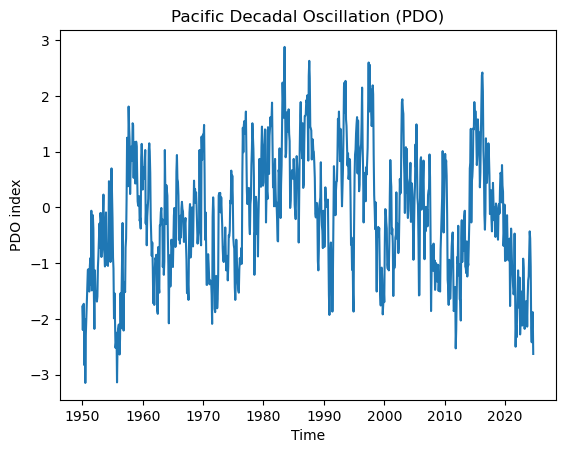

In [5]:
plt.plot(ds_pdo['time'],ds_pdo['PDO']) ;
plt.title('Pacific Decadal Oscillation (PDO)')
plt.xlabel('Time')
plt.ylabel('PDO index')
plt.show()

In [6]:
model_file = '/scratch/asarker3/clim680/conv_data_181/tos1.nc'
df_ens = xr.open_dataset(model_file)
df_ens

/home/asarker3/.conda/envs/clim_data/lib/python3.10/site-packages/xarray/backends/plugins.py:65: RuntimeWarning: Engine 'gini' loading failed:
cannot import name 'deprecated' from 'typing_extensions' (/home/asarker3/.conda/envs/clim_data/lib/python3.10/site-packages/typing_extensions.py)
  warnings.warn(f"Engine {name!r} loading failed:\n{ex}", RuntimeWarning)


<xarray.Dataset>
Dimensions:  (time: 1980, lat: 181, lon: 361)
Coordinates:
  * time     (time) datetime64[ns] 1850-01-16T12:00:00 ... 2014-12-16T12:00:00
  * lat      (lat) float64 -90.0 -89.0 -88.0 -87.0 -86.0 ... 87.0 88.0 89.0 90.0
  * lon      (lon) float64 0.0 1.0 2.0 3.0 4.0 ... 356.0 357.0 358.0 359.0 360.0
Data variables:
    tos      (time, lat, lon) float32 ...

In [7]:
cntl_filename = "/scratch/asarker3/clim680/conv_data_181/picontrol2.nc"
df_cntl = xr.open_dataset(cntl_filename)
df_cntl

/home/asarker3/.conda/envs/clim_data/lib/python3.10/site-packages/xarray/coding/times.py:526: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  dtype = _decode_cf_datetime_dtype(data, units, calendar, self.use_cftime)
/home/asarker3/.conda/envs/clim_data/lib/python3.10/site-packages/xarray/core/indexing.py:422: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  return np.asarray(array[self.key], dtype=None)


<xarray.Dataset>
Dimensions:  (time: 3600, lat: 181, lon: 361)
Coordinates:
  * time     (time) object 3550-01-16 12:00:00 ... 3849-12-16 12:00:00
  * lat      (lat) float64 -90.0 -89.0 -88.0 -87.0 -86.0 ... 87.0 88.0 89.0 90.0
  * lon      (lon) float64 0.0 1.0 2.0 3.0 4.0 ... 356.0 357.0 358.0 359.0 360.0
Data variables:
    tos      (time, lat, lon) float32 ...

# Matching the time range of datasets

In [8]:
ens_tos = df_ens.tos.sel(time=slice(ds_pdo['time'][0],df_ens['time'][-1]))


In [9]:
ds_pdo = ds_pdo.sel(time=slice(ds_pdo['time'][0], df_ens['time'][-1]))
ds_pdo = ds_pdo.reset_coords(drop=False) 

In [10]:
print(len(ens_tos['time']))
print(len(ds_pdo['time']))

780
780


### Replaceing the dates in control runs with teh dates of historical runs for ease of calculation

In [11]:
df_cntl_subset = df_cntl.tos.sel(time=slice(df_cntl.time[0], df_cntl.time[779]))

In [12]:
df_cntl_subset

<xarray.DataArray 'tos' (time: 780, lat: 181, lon: 361)>
[50965980 values with dtype=float32]
Coordinates:
  * time     (time) object 3550-01-16 12:00:00 ... 3614-12-16 12:00:00
  * lat      (lat) float64 -90.0 -89.0 -88.0 -87.0 -86.0 ... 87.0 88.0 89.0 90.0
  * lon      (lon) float64 0.0 1.0 2.0 3.0 4.0 ... 356.0 357.0 358.0 359.0 360.0
Attributes:
    regrid_method:  bilinear

In [13]:
cntl_tos = df_cntl_subset.assign_coords(time=ds_pdo.time[:780])

In [14]:
cntl_tos

<xarray.DataArray 'tos' (time: 780, lat: 181, lon: 361)>
[50965980 values with dtype=float32]
Coordinates:
  * time     (time) datetime64[ns] 1950-01-01 1950-02-01 ... 2014-12-01
  * lat      (lat) float64 -90.0 -89.0 -88.0 -87.0 -86.0 ... 87.0 88.0 89.0 90.0
  * lon      (lon) float64 0.0 1.0 2.0 3.0 4.0 ... 356.0 357.0 358.0 359.0 360.0
Attributes:
    regrid_method:  bilinear

In [15]:
ens_tos = ens_tos.assign_coords(time=ds_pdo.time[:780])

In [16]:
ens_tos

<xarray.DataArray 'tos' (time: 780, lat: 181, lon: 361)>
[50965980 values with dtype=float32]
Coordinates:
  * time     (time) datetime64[ns] 1950-01-01 1950-02-01 ... 2014-12-01
  * lat      (lat) float64 -90.0 -89.0 -88.0 -87.0 -86.0 ... 87.0 88.0 89.0 90.0
  * lon      (lon) float64 0.0 1.0 2.0 3.0 4.0 ... 356.0 357.0 358.0 359.0 360.0
Attributes:
    regrid_method:  bilinear

### Finding anomalies

In [17]:
ens_climo = ens_tos.groupby('time.month').mean()
ens_anoms = ens_tos.groupby('time.month') - ens_climo
#ens_anoms

In [18]:
cntl_climo = cntl_tos.groupby('time.month').mean()
cntl_anoms = cntl_tos.groupby('time.month') - cntl_climo

### Plotting for a point

In [19]:
pt=ens_anoms.sel(lat=0,lon=150,method='nearest')
#pt

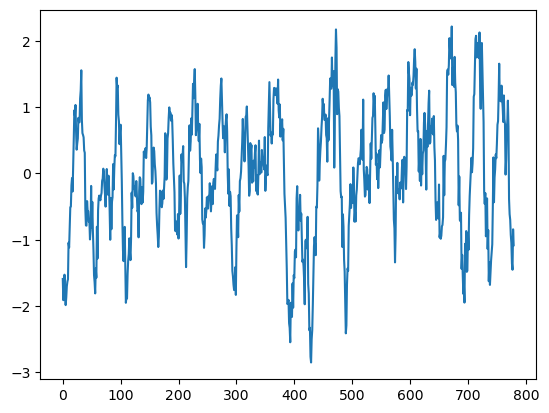

In [20]:
plt.plot(pt)

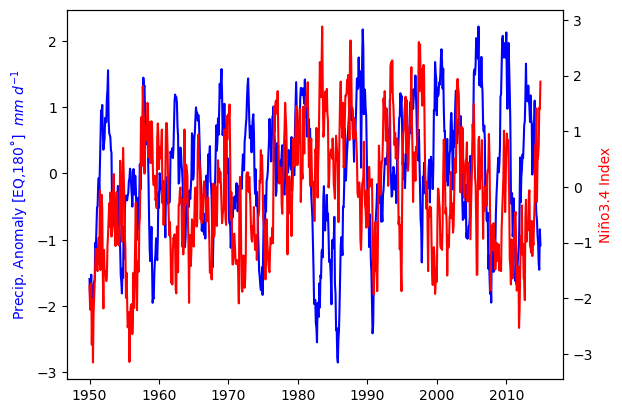

In [21]:
fig, ax1 = plt.subplots()

ax2 = ax1.twinx()
ax1.plot(pt['time'],pt,'b')
ax2.plot(ds_pdo['time'],ds_pdo['PDO'],'r')

ax1.set_ylabel('Precip. Anomaly [EQ,180˚]  $mm\;d^{-1}$', color='b')
ax2.set_ylabel('Niño3.4 Index', color='r') ;

In [22]:
ds_pdo

<xarray.Dataset>
Dimensions:  (time: 780)
Coordinates:
  * time     (time) datetime64[ns] 1950-01-01 1950-02-01 ... 2014-12-01
Data variables:
    PDO      (time) float64 -1.78 -2.2 -1.75 -1.73 -2.83 ... 0.74 1.42 1.4 1.89

### Correlation over a domain



In [23]:
r_map_hist = xr.corr(ds_pdo['PDO'],ens_anoms,dim='time')
#r_map

In [24]:
np.all(np.isnan(r_map_hist))

<xarray.DataArray ()>
array(False)

In [25]:
r_map_cntl = xr.corr(ds_pdo['PDO'],cntl_anoms,dim='time')

In [26]:
np.all(np.isnan(r_map_cntl))

<xarray.DataArray ()>
array(False)

### Plot the correlation map

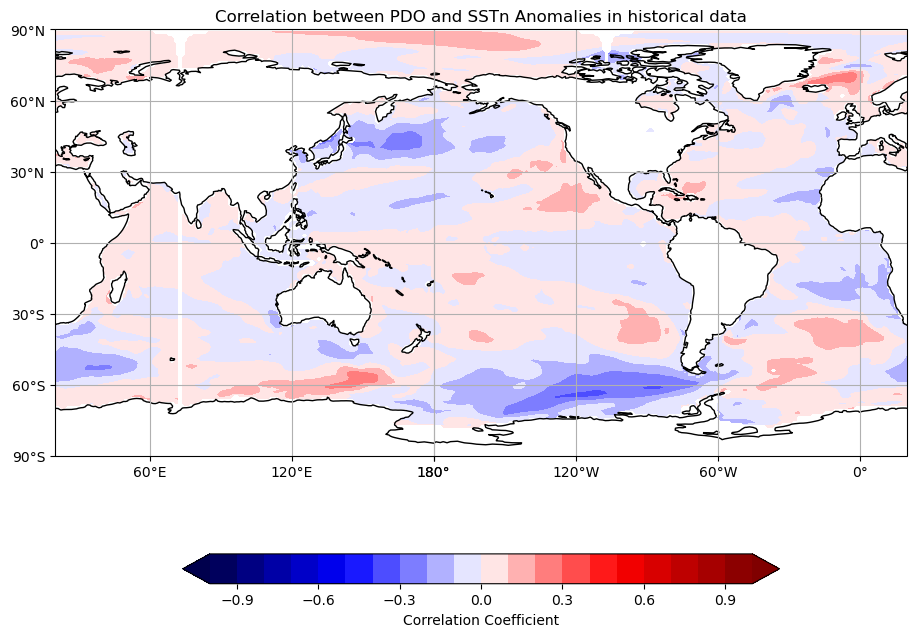

In [27]:
clevs=np.arange(-1,1.1,0.1)

fig = plt.figure(figsize=(11,8.5))

# Set the axes using the specified map projection
ax=plt.axes(projection=ccrs.PlateCarree(central_longitude=200))

# Add cyclic point
data=r_map_hist
data,lon=add_cyclic_point(r_map_hist,coord=ens_anoms['lon'])

# Make a filled contour plot
cs=ax.contourf(lon,ens_anoms['lat'],
            data,clevs,
            transform=ccrs.PlateCarree(),
            cmap='seismic',extend='both')

# Add coastlines
ax.coastlines()

# Add gridlines
ax.gridlines()

label_latlon(ax,np.arange(-180,181,60),np.arange(-90,91,30))
# Define the xticks for longtitude 
#ax.set_xticks(np.arange(-180,181,60),crs=ccrs.PlateCarree())
#lon_formatter=cticker.LongitudeFormatter()
#ax.xaxis.set_major_formatter(lon_formatter)

# Define ytick for latitude
#ax.set_yticks(np.arange(-90,91,30),crs=ccrs.PlateCarree())
#lat_formatter=cticker.LatitudeFormatter()
#ax.yaxis.set_major_formatter(lat_formatter)

# Call colorbar
cbar=plt.colorbar(cs,orientation='horizontal',shrink=0.7,
                 label='Correlation Coefficient')

# Add title
plt.title('Correlation between PDO and SSTn Anomalies in historical data') ;

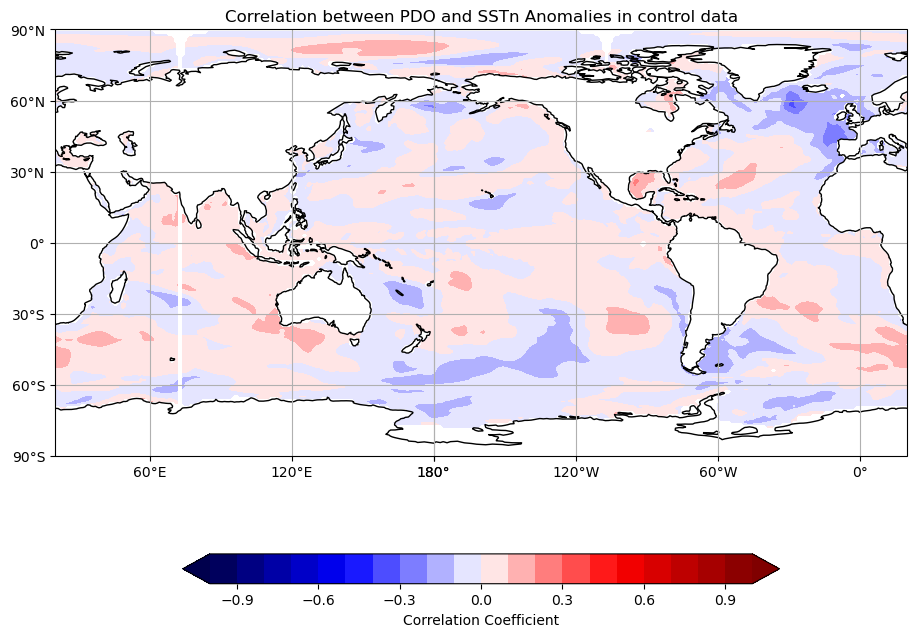

In [28]:
clevs=np.arange(-1,1.1,0.1)

fig = plt.figure(figsize=(11,8.5))

# Set the axes using the specified map projection
ax=plt.axes(projection=ccrs.PlateCarree(central_longitude=200))

# Add cyclic point
data=r_map_cntl
data,lon=add_cyclic_point(r_map_cntl,coord=ens_anoms['lon'])

# Make a filled contour plot
cs=ax.contourf(lon,cntl_anoms['lat'],
            data,clevs,
            transform=ccrs.PlateCarree(),
            cmap='seismic',extend='both')

# Add coastlines
ax.coastlines()

# Add gridlines
ax.gridlines()

label_latlon(ax,np.arange(-180,181,60),np.arange(-90,91,30))
# Define the xticks for longtitude 
#ax.set_xticks(np.arange(-180,181,60),crs=ccrs.PlateCarree())
#lon_formatter=cticker.LongitudeFormatter()
#ax.xaxis.set_major_formatter(lon_formatter)

# Define ytick for latitude
#ax.set_yticks(np.arange(-90,91,30),crs=ccrs.PlateCarree())
#lat_formatter=cticker.LatitudeFormatter()
#ax.yaxis.set_major_formatter(lat_formatter)

# Call colorbar
cbar=plt.colorbar(cs,orientation='horizontal',shrink=0.7,
                 label='Correlation Coefficient')

# Add title
plt.title('Correlation between PDO and SSTn Anomalies in control data') ;

### Statistical Significance of a Correlation

In [29]:
np.any(np.isnan(ens_anoms))

<xarray.DataArray 'tos' ()>
array(True)

In [30]:
nx=len(ens_anoms['lon'])
ny=len(ens_anoms['lat'])

p_array_hist=np.zeros((ny,nx))
r_array_hist=np.zeros((ny,nx))

t_start = time.perf_counter()
for i in range(nx):
    for j in range(ny):
        if not np.any(np.isnan(ens_anoms[:,j,i])):
            #print(j,i)
        
            r,p = pearsonr(ds_pdo['PDO'],ens_anoms[:,j,i])
            r_array_hist[j,i] = r
            p_array_hist[j,i] = p
#r_array.shape
print(f"{time.perf_counter()-t_start:0.2f} s")

/home/asarker3/.conda/envs/clim_data/lib/python3.10/site-packages/scipy/stats/stats.py:4023: PearsonRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(PearsonRConstantInputWarning())
/home/asarker3/.conda/envs/clim_data/lib/python3.10/site-packages/scipy/stats/stats.py:4023: PearsonRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(PearsonRConstantInputWarning())
/home/asarker3/.conda/envs/clim_data/lib/python3.10/site-packages/scipy/stats/stats.py:4023: PearsonRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(PearsonRConstantInputWarning())
/home/asarker3/.conda/envs/clim_data/lib/python3.10/site-packages/scipy/stats/stats.py:4023: PearsonRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(PearsonRConstantInputWarning())
/home/asarker3/.conda/envs/c

31.39 s


/home/asarker3/.conda/envs/clim_data/lib/python3.10/site-packages/scipy/stats/stats.py:4023: PearsonRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(PearsonRConstantInputWarning())
/home/asarker3/.conda/envs/clim_data/lib/python3.10/site-packages/scipy/stats/stats.py:4023: PearsonRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(PearsonRConstantInputWarning())
/home/asarker3/.conda/envs/clim_data/lib/python3.10/site-packages/scipy/stats/stats.py:4023: PearsonRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(PearsonRConstantInputWarning())
/home/asarker3/.conda/envs/clim_data/lib/python3.10/site-packages/scipy/stats/stats.py:4023: PearsonRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(PearsonRConstantInputWarning())
/home/asarker3/.conda/envs/c

the warnings in here are for points where data is constantly zero, theses points are near the corner of the map. this is not true for the whole map.

In [31]:
nx=len(cntl_anoms['lon'])
ny=len(cntl_anoms['lat'])

p_array_cntl=np.zeros((ny,nx))
r_array_cntl=np.zeros((ny,nx))

t_start = time.perf_counter()
for i in range(nx):
    for j in range(ny):
        if not np.any(np.isnan(cntl_anoms[:,j,i])):
            r,p = pearsonr(ds_pdo['PDO'],cntl_anoms[:,j,i])
            r_array_cntl[j,i] = r
            p_array_cntl[j,i] = p
#r_array.shape
print(f"{time.perf_counter()-t_start:0.2f} s")

/home/asarker3/.conda/envs/clim_data/lib/python3.10/site-packages/scipy/stats/stats.py:4023: PearsonRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(PearsonRConstantInputWarning())
/home/asarker3/.conda/envs/clim_data/lib/python3.10/site-packages/scipy/stats/stats.py:4023: PearsonRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(PearsonRConstantInputWarning())
/home/asarker3/.conda/envs/clim_data/lib/python3.10/site-packages/scipy/stats/stats.py:4023: PearsonRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(PearsonRConstantInputWarning())
/home/asarker3/.conda/envs/clim_data/lib/python3.10/site-packages/scipy/stats/stats.py:4023: PearsonRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(PearsonRConstantInputWarning())
/home/asarker3/.conda/envs/c

31.89 s


/home/asarker3/.conda/envs/clim_data/lib/python3.10/site-packages/scipy/stats/stats.py:4023: PearsonRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(PearsonRConstantInputWarning())
/home/asarker3/.conda/envs/clim_data/lib/python3.10/site-packages/scipy/stats/stats.py:4023: PearsonRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(PearsonRConstantInputWarning())
/home/asarker3/.conda/envs/clim_data/lib/python3.10/site-packages/scipy/stats/stats.py:4023: PearsonRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(PearsonRConstantInputWarning())
/home/asarker3/.conda/envs/clim_data/lib/python3.10/site-packages/scipy/stats/stats.py:4023: PearsonRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(PearsonRConstantInputWarning())
/home/asarker3/.conda/envs/c

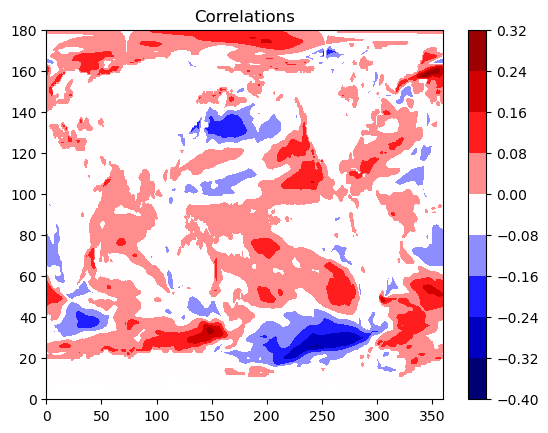

In [32]:
plt.contourf(r_array_hist,cmap='seismic')
plt.title("Correlations")
plt.colorbar() ;

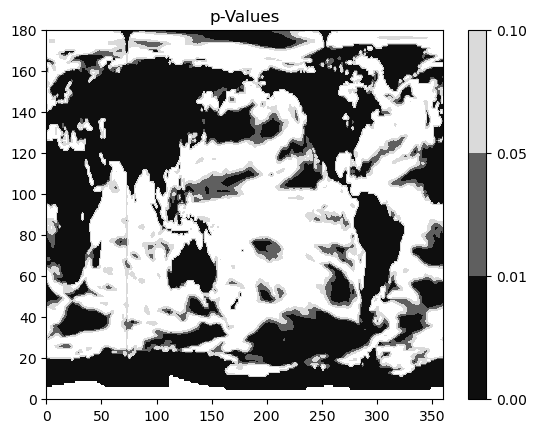

In [33]:
plt.contourf(p_array_hist,[0,0.01,0.05,0.1],cmap='Greys_r')
plt.title("p-Values")
plt.colorbar() ;

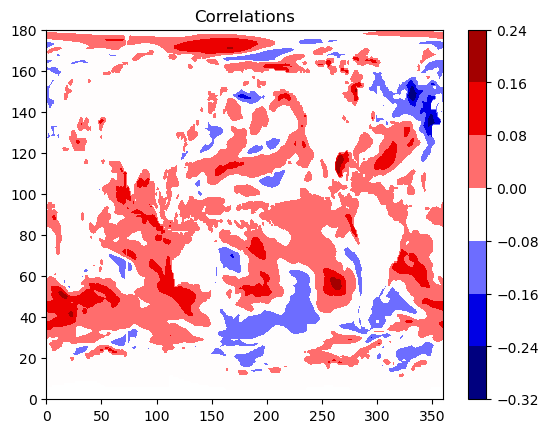

In [34]:
plt.contourf(r_array_cntl,cmap='seismic')
plt.title("Correlations")
plt.colorbar() ;

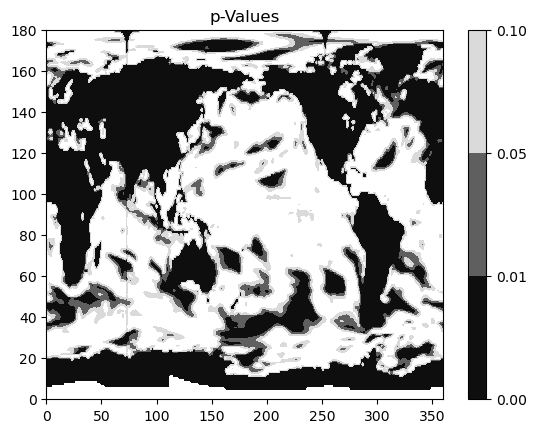

In [35]:
plt.contourf(p_array_cntl,[0,0.01,0.05,0.1],cmap='Greys_r')
plt.title("p-Values")
plt.colorbar() ;

### Plot the correlation including significance

In [36]:
mask_sig=np.where(p_array_hist<0.05,r_array_hist,np.nan)

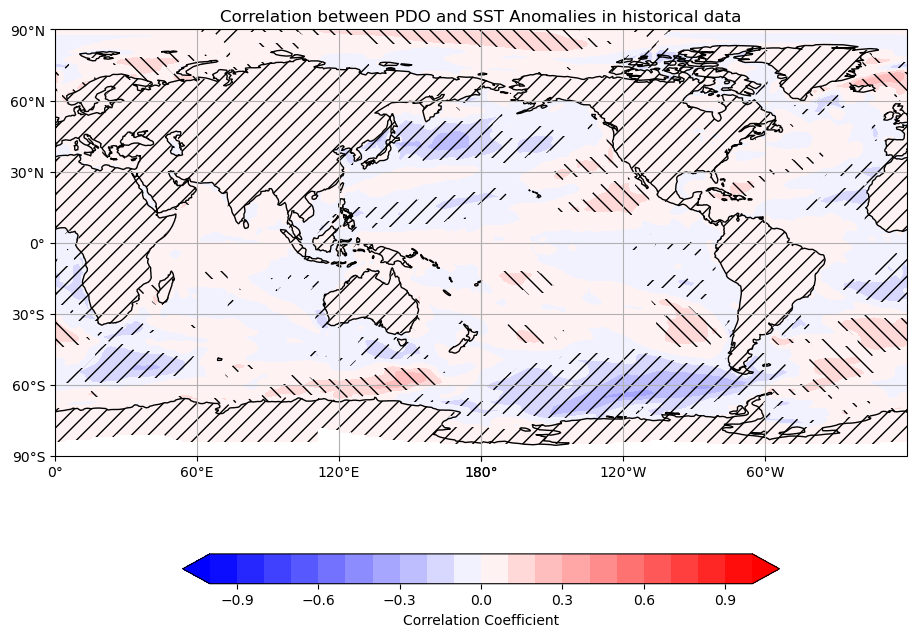

In [37]:
clevs=np.arange(-1,1.1,0.1)

fig = plt.figure(figsize=(11,8.5))

# Set the axes using the specified map projection
ax=plt.axes(projection=ccrs.PlateCarree(central_longitude=180))

# Add cyclic point
data=r_array_hist
data,lon=add_cyclic_point(data,coord=ens_anoms['lon'])
mask_data,lons=add_cyclic_point(mask_sig,coord=ens_anoms['lon'])

# Make a filled contour plot
cs=ax.contourf(lon,ens_anoms['lat'],
            data,clevs,
            transform=ccrs.PlateCarree(),
            cmap='bwr',extend='both')

ax.contourf(lon,ens_anoms['lat'],mask_data,[0,1],
            transform = ccrs.PlateCarree(),colors='None',
            hatches=['//','\\\\'],extend='both',alpha=0)

# Add coastlines
ax.coastlines()

# Add gridlines
ax.gridlines()

# Define the xticks for longtitude 
ax.set_xticks(np.arange(-180,181,60),crs=ccrs.PlateCarree())
lon_formatter=cticker.LongitudeFormatter()
ax.xaxis.set_major_formatter(lon_formatter)

# Define ytick for latitude
ax.set_yticks(np.arange(-90,91,30),crs=ccrs.PlateCarree())
lat_formatter=cticker.LatitudeFormatter()
ax.yaxis.set_major_formatter(lat_formatter)

# Call colorbar
cbar=plt.colorbar(cs,orientation='horizontal',shrink=0.7,
                 label='Correlation Coefficient')

# Add title
plt.title('Correlation between PDO and SST Anomalies in historical data') ;

In [38]:
mask_sig=np.where(p_array_cntl<0.05,r_array_cntl,np.nan)

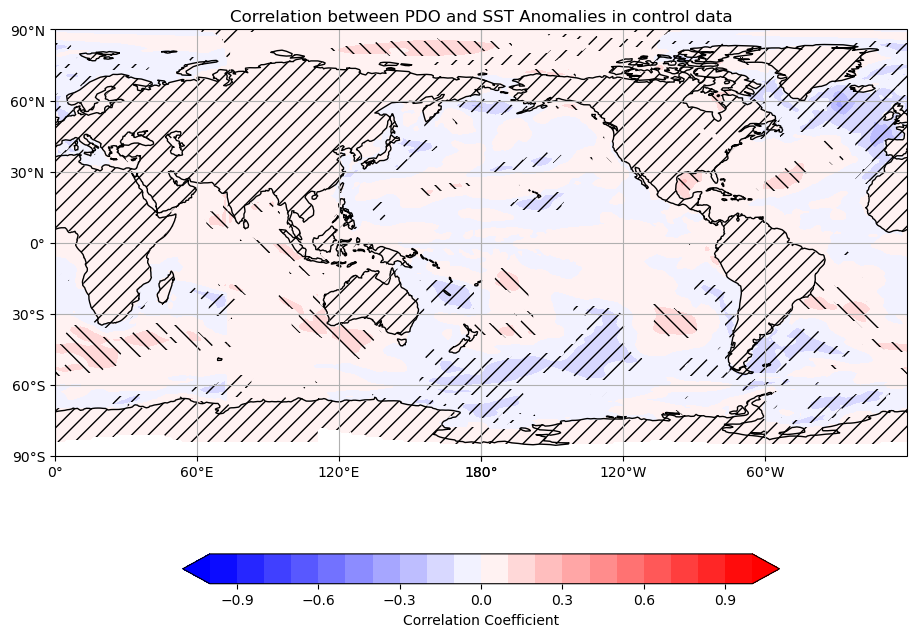

In [39]:
clevs=np.arange(-1,1.1,0.1)

fig = plt.figure(figsize=(11,8.5))

# Set the axes using the specified map projection
ax=plt.axes(projection=ccrs.PlateCarree(central_longitude=180))

# Add cyclic point
data=r_array_cntl
data,lon=add_cyclic_point(data,coord=cntl_anoms['lon'])
mask_data,lons=add_cyclic_point(mask_sig,coord=cntl_anoms['lon'])

# Make a filled contour plot
cs=ax.contourf(lon,cntl_anoms['lat'],
            data,clevs,
            transform=ccrs.PlateCarree(),
            cmap='bwr',extend='both')

ax.contourf(lon,cntl_anoms['lat'],mask_data,[0,1],
            transform = ccrs.PlateCarree(),colors='None',
            hatches=['//','\\\\'],extend='both',alpha=0)

# Add coastlines
ax.coastlines()

# Add gridlines
ax.gridlines()

# Define the xticks for longtitude 
ax.set_xticks(np.arange(-180,181,60),crs=ccrs.PlateCarree())
lon_formatter=cticker.LongitudeFormatter()
ax.xaxis.set_major_formatter(lon_formatter)

# Define ytick for latitude
ax.set_yticks(np.arange(-90,91,30),crs=ccrs.PlateCarree())
lat_formatter=cticker.LatitudeFormatter()
ax.yaxis.set_major_formatter(lat_formatter)

# Call colorbar
cbar=plt.colorbar(cs,orientation='horizontal',shrink=0.7,
                 label='Correlation Coefficient')

# Add title
plt.title('Correlation between PDO and SST Anomalies in control data') ;